In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.optimizers import Adam


from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.resnet import ResNet101
from tensorflow.keras.applications import ResNet50
from keras.applications.vgg16 import VGG16

import random
import os
import warnings
warnings.filterwarnings('ignore')
print('compeleted')

compeleted


### Data Visualizationn

In [2]:
image_shape = (224,224)
batch_size = 64

train_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

# apply scaling only becouse data already augmented
train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale = 1/255.)

# load training data
print("Training Images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='training')

# load validation data (20% of training data)
print("Validating Images:")
valid_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=False,
                                               subset='validation')

# loading test data(val data)
print('Test Images:')
test_data = test_datagen.flow_from_directory(valid_dir,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=False)

Training Images:
Found 56251 images belonging to 38 classes.
Validating Images:
Found 14044 images belonging to 38 classes.
Test Images:
Found 17572 images belonging to 38 classes.


In [3]:
classes=list(train_data.class_indices)
print(len(classes),'\n',classes)

38 
 ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Targ

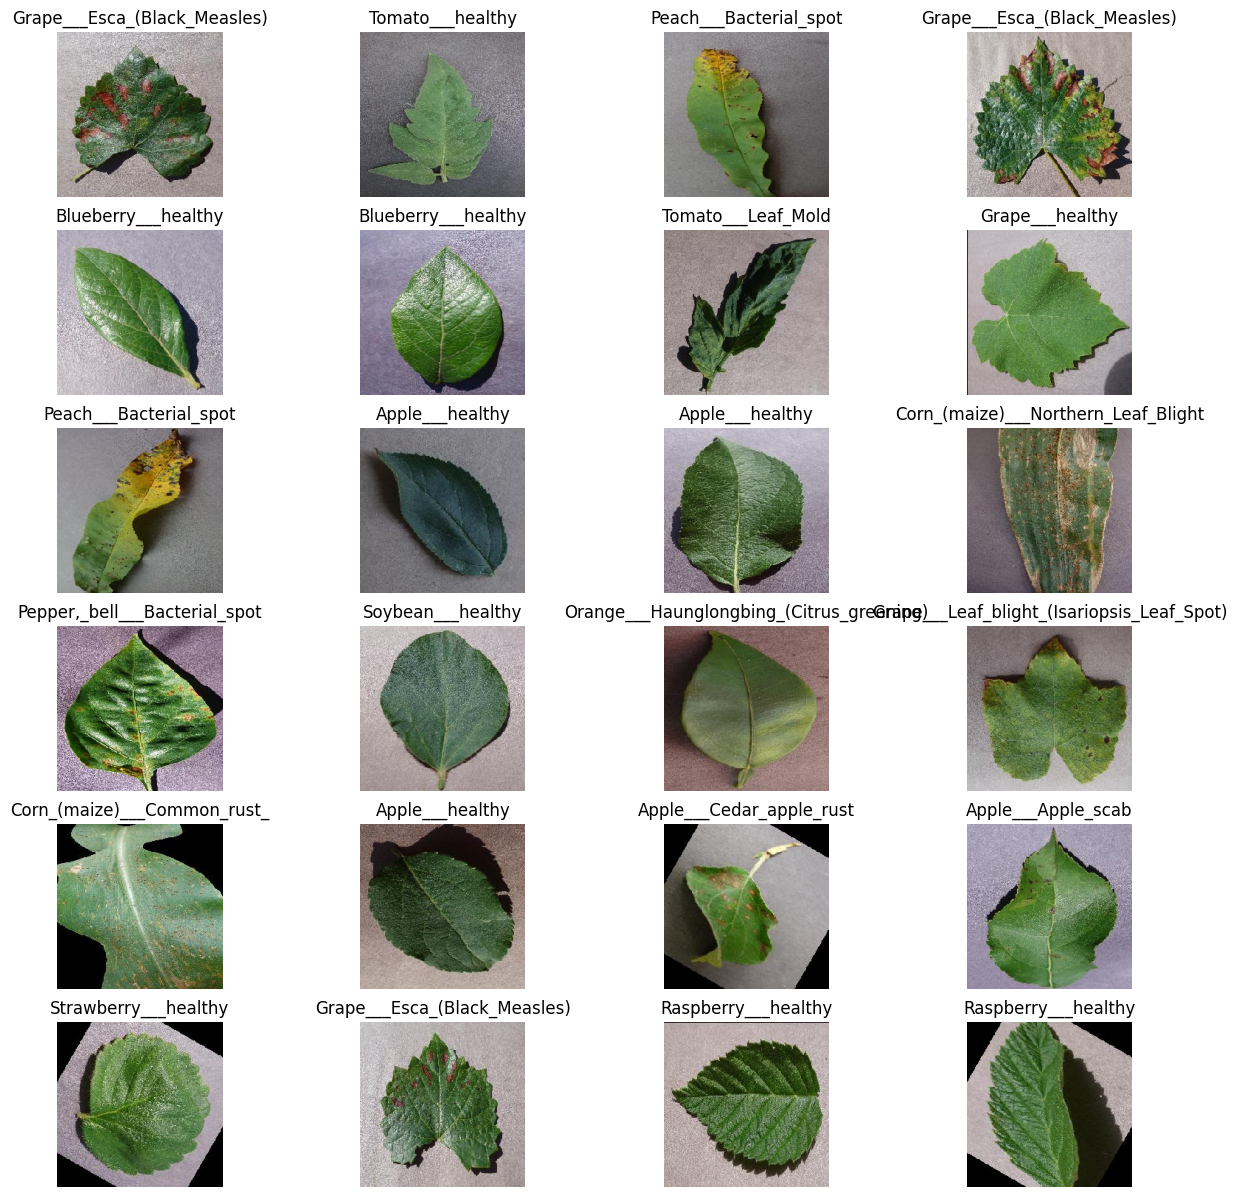

In [4]:
max_images = 24
plt.figure(figsize=(15,15))
for X_batch, y_batch in train_data:
    for i in range(min(max_images, len(X_batch))):  
        plt.subplot(6,4, i + 1)  
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i] == 1)[0][0]])  
        plt.axis('off')  
    plt.show()  
    break  

### ResNet Model

In [5]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# iterate through its layers and frezzing them
for layer in resnet.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# Model architecure
last_output = resnet.output

x = GlobalAveragePooling2D()(last_output)

x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)

x = Dense(38, activation='softmax')(x)

resnet_model = Model(inputs=resnet.input, outputs=x)

# opt = Adam(learning_rate=0.0001)
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
resnet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,238,182 (92.46 MB)

 Trainable params: 650,470 (2.48 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
model_checkpoint = ModelCheckpoint('/kaggle/working/resnet_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)

history =resnet_model.fit(train_data,
                        validation_data=valid_data,
                        epochs=100,  
                        batch_size=64, 
                        callbacks=[model_checkpoint, early_stopping])

Epoch 1/100


I0000 00:00:1732009156.209507     120 service.cc:145] XLA service 0x7d3f68002df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732009156.209559     120 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/879 ━━━━━━━━━━━━━━━━━━━━ 1:19 91ms/step - accuracy: 0.0156 - loss: 3.7193      

I0000 00:00:1732009165.315920     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.0412 - loss: 3.5256
Epoch 1: val_accuracy improved from -inf to 0.08559, saving model to /kaggle/working/resnet_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 475s 519ms/step - accuracy: 0.0412 - loss: 3.5255 - val_accuracy: 0.0856 - val_loss: 3.1347
Epoch 2/100
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.1126 - loss: 3.0596
Epoch 2: val_accuracy improved from 0.08559 to 0.18784, saving model to /kaggle/working/resnet_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 194s 220ms/step - accuracy: 0.1126 - loss: 3.0595 - val_accuracy: 0.1878 - val_loss: 2.7551
Epoch 3/100
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.1909 - loss: 2.7362
Epoch 3: val_accuracy improved from 0.18784 to 0.22301, saving model to /kaggle/working/resnet_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 188s 212ms/step - accuracy: 0.1909 - loss: 2.7361 - val_accuracy: 0.2230 - val_loss: 2.5697
Epoch 4/100
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accurac

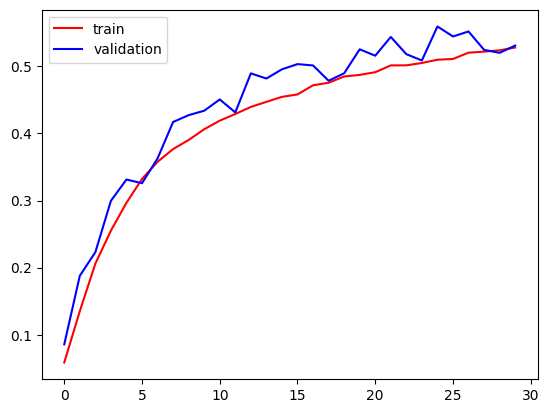

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

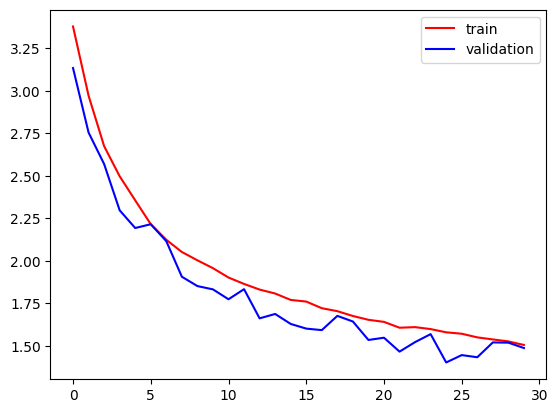

In [12]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [13]:
best_model = load_model('resnet_model.keras')

test_loss, test_accuracy = best_model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

275/275 ━━━━━━━━━━━━━━━━━━━━ 128s 454ms/step - accuracy: 0.5430 - loss: 1.4337
Test Loss: 1.3943
Test Accuracy: 0.5655


### VGG_16 Model

In [14]:
# use VGG16 from Keres
vgg_16 = VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3))

# iterate through its layers and frezzing them expect the last block (last 5 layers)
for layer in vgg_16.layers[:-5]:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
# take the last layer from VGG16 and link it with my fully connected layer
last_output = vgg_16.output

# take the last layer from VGG16 and link it with my fully connected layer
x = GlobalAveragePooling2D()(last_output)

x = Dense(256, activation='elu', kernel_initializer=GlorotNormal())(x)
x = Dropout(0.2)(x)

x = Dense(256, activation='elu', kernel_initializer=GlorotNormal())(x)
x = Dropout(0.2)(x)

x = Dense(64, activation='elu', kernel_initializer=GlorotNormal())(x)
x = BatchNormalization()(x)


x = Dense(38, activation='softmax')(x)


vgg_model = Model(inputs=vgg_16.input, outputs=x)

vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,930,982 (56.96 MB)

 Trainable params: 7,295,590 (27.83 MB)

 Non-trainable params: 7,635,392 (29.13 MB)

In [16]:
model_checkpoint = ModelCheckpoint('/kaggle/working/vgg_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)

history =vgg_model.fit(train_data,
                        validation_data=valid_data,
                        epochs=10,  
                        batch_size=64, 
                        callbacks=[model_checkpoint, early_stopping])

Epoch 1/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.5017 - loss: 1.8069
Epoch 1: val_accuracy improved from -inf to 0.92175, saving model to /kaggle/working/vgg_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 284s 297ms/step - accuracy: 0.5020 - loss: 1.8059 - val_accuracy: 0.9217 - val_loss: 0.2585
Epoch 2/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9403 - loss: 0.1966
Epoch 2: val_accuracy improved from 0.92175 to 0.93862, saving model to /kaggle/working/vgg_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 184s 208ms/step - accuracy: 0.9403 - loss: 0.1965 - val_accuracy: 0.9386 - val_loss: 0.1849
Epoch 3/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9638 - loss: 0.1199
Epoch 3: val_accuracy improved from 0.93862 to 0.95770, saving model to /kaggle/working/vgg_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 187s 211ms/step - accuracy: 0.9638 - loss: 0.1199 - val_accuracy: 0.9577 - val_loss: 0.1372
Epoch 4/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy

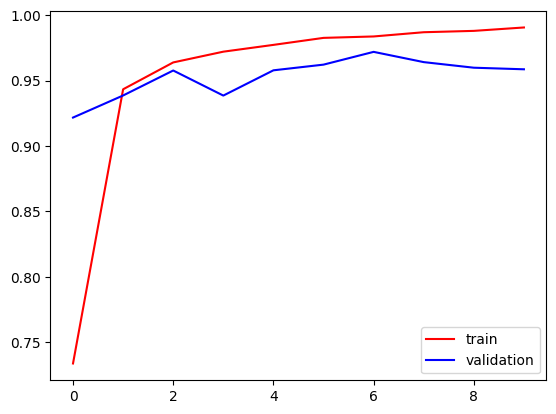

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

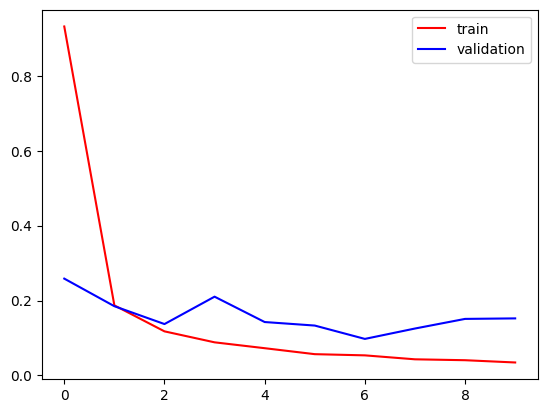

In [18]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [19]:
best_model = load_model('/kaggle/working/vgg_model.keras')

test_loss, test_accuracy = best_model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

275/275 ━━━━━━━━━━━━━━━━━━━━ 68s 243ms/step - accuracy: 0.9799 - loss: 0.0781
Test Loss: 0.0822
Test Accuracy: 0.9756
